# Animal Insights Data Exploration
This notebook explores the Austin Animal Center dataset for insights that will inform our machine learning model.

## Cell 1: Setup and Configuration
Run this first to configure Jupyter for optimal data science experience.

In [9]:
# Jupyter magic commands for better notebook experience
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Configure pandas display options
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

print("✅ Jupyter configured successfully")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
✅ Jupyter configured successfully


## Cell 2: Import Libraries
Import all required libraries with error handling.

✅ boto3 imported successfully
✅ Using seaborn-v0_8 style


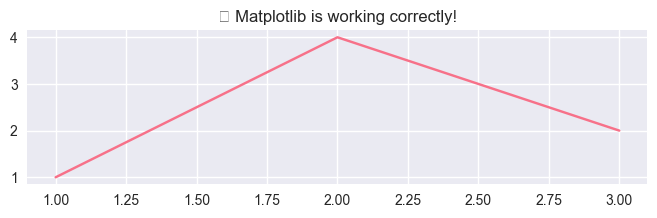

✅ All plotting libraries configured successfully
✅ Cell 2 completed - libraries imported


In [ ]:
# Import core libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Test each import individually to catch specific errors
try:
    import boto3
    print("✅ boto3 imported successfully")
except ImportError as e:
    print(f"❌ boto3 import failed: {e}")
    print("Fix: pip install boto3")

# Set up plotting with error handling
try:
    # Try different seaborn styles (newer versions changed names)
    try:
        plt.style.use('seaborn-v0_8')
        print("✅ Using seaborn-v0_8 style")
    except:
        try:
            plt.style.use('seaborn')
            print("✅ Using seaborn style") 
        except:
            plt.style.use('default')
            print("✅ Using default style")
    
    sns.set_palette("husl")
    
    # Test matplotlib setup
    plt.figure(figsize=(8, 2))
    plt.plot([1, 2, 3], [1, 4, 2])
    plt.title("✅ Matplotlib is working correctly!")
    plt.show()
    
    print("✅ All plotting libraries configured successfully")
    
except Exception as e:
    print(f"❌ Plotting setup failed: {e}")
    print("Try running: pip install matplotlib seaborn")

print("✅ Cell 2 completed - libraries imported")

## Cell 3: Configuration and Data Loading
Set up AWS configuration and load data from S3.

In [ ]:
# Configuration and Model Loading
import json
import os
from pathlib import Path

import boto3
try:
    import sagemaker
except ImportError:
    sagemaker = None

def load_config():
    """Load configuration with multiple fallback options"""
    # Option 1: Load from config.json (recommended)
    config_file = Path('./config.json')
    if config_file.exists():
        with open(config_file) as f:
            config = json.load(f)
        print(f"Configuration loaded from {config_file}")
        return config
    
    # Option 2: Try environment variables
    if os.environ.get('S3_BUCKET_NAME'):
        config = {
            's3_bucket_name': os.environ['S3_BUCKET_NAME'],
            'aws_region': os.environ.get('AWS_REGION', 'us-east-1'),
            'sagemaker_role_arn': os.environ.get('SAGEMAKER_ROLE_ARN', '')
        }
        print("Configuration loaded from environment variables")
        return config
    
    # Option 3: Interactive input (beginner-friendly fallback)
    print("Configuration not found. Let's set it up interactively.")
    print("(You can skip this by running: python config_generator.py)")
    
    config = {}
    bucket_name = input("Enter your S3 bucket name (from terraform output): ").strip()
    config['s3_bucket_name'] = bucket_name
    config['aws_region'] = 'us-east-1'
    
    # For deployment notebook, SageMaker role is more important
    sagemaker_role = input("Enter SageMaker role ARN (required for deployment): ").strip()
    if sagemaker_role:
        config['sagemaker_role_arn'] = sagemaker_role
    
    # Save for next time
    with open('./config.json', 'w') as f:
        json.dump(config, f, indent=2)
    print("Configuration saved to config.json for future use")
    return config

# Load configuration
try:
    config = load_config()
    BUCKET_NAME = config['s3_bucket_name']
    AWS_REGION = config.get('aws_region', 'us-east-1')
    SAGEMAKER_ROLE = config.get('sagemaker_role_arn', None)
    
    print(f"Using S3 bucket: {BUCKET_NAME}")
    print(f"Using AWS region: {AWS_REGION}")
    
    if SAGEMAKER_ROLE:
        print(f"SageMaker role: {SAGEMAKER_ROLE[:50]}...")
        if sagemaker is None:
            print("SageMaker package not available")
            sagemaker_session = None
        else:
            boto_sess = boto3.Session(region_name=AWS_REGION)
            sagemaker_session = sagemaker.Session(boto_session=boto_sess)
            print(f"SageMaker session initialized in {AWS_REGION} - deployment enabled")
    else:
        print("No SageMaker role configured - local testing only")
        sagemaker_session = None

except KeyboardInterrupt:
    print("Configuration cancelled. Please run this cell again when ready.")
    BUCKET_NAME = None
    AWS_REGION = 'us-east-1'
    SAGEMAKER_ROLE = None
    sagemaker_session = None

class AnimalDataExplorer:
    """Class to explore and analyze animal shelter data"""
    
    def __init__(self, s3_bucket=None, data_path=None):
        self.data = None
        self.s3_bucket = s3_bucket
        self.data_path = data_path
        
    def load_data(self):
        """Load data from S3 or local file"""
        if self.s3_bucket:
            try:
                s3 = boto3.client('s3')
                obj = s3.get_object(Bucket=self.s3_bucket, 
                                  Key='raw/austin_animal_outcomes.csv')
                self.data = pd.read_csv(obj['Body'])
                print(f"Data loaded from S3: {len(self.data):,} records")
            except Exception as e:
                print(f"Failed to load from S3: {e}")
                print("Trying local file instead...")
                self.data = pd.read_csv('../data/austin_animal_outcomes.csv')
                print(f"Data loaded from local file: {len(self.data):,} records")
        else:
            # Load from local file
            self.data = pd.read_csv(self.data_path or '../data/austin_animal_outcomes.csv')
            print(f"Data loaded from local file: {len(self.data):,} records")
            
        return self

# Initialize explorer with S3 bucket
explorer = AnimalDataExplorer(s3_bucket=BUCKET_NAME)
explorer.load_data()

Configuration loaded from config.json
Using S3 bucket: animal-insights-ae1a1bd9
Using AWS region: us-east-1
SageMaker role: arn:aws:iam::239285815587:role/sagemaker-execution...
SageMaker session initialized in us-east-1 - deployment enabled
Data loaded from S3: 173,775 records


## Cell 4: Basic Data Information
Examine the structure and quality of our dataset.

In [12]:
# Display basic information about the dataset
print("Dataset Overview")
print("-" * 50)
print(f"Shape: {explorer.data.shape}")
print(f"Memory usage: {explorer.data.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

print("\nSample Data:")
display(explorer.data.head())

print("\nColumn Information:")
explorer.data.info()

print("\nMissing Values:")
missing = explorer.data.isnull().sum()
missing_pct = (missing / len(explorer.data)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Missing %': missing_pct
}).sort_values('Missing %', ascending=False)
display(missing_df[missing_df['Missing Count'] > 0])

Dataset Overview
--------------------------------------------------
Shape: (173775, 12)
Memory usage: 128.3 MB

Sample Data:


,Animal ID,Date of Birth,Name,DateTime,MonthYear,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
0,A668305,2012-12-01,NaN,2013-12-02T00:00:00-05:00,12-2013,Transfer,Partner,Other,Unknown,1 year,Turtle Mix,Brown/Yellow
1,A673335,2012-02-22,NaN,2014-02-22T00:00:00-05:00,02-2014,Euthanasia,Suffering,Other,Unknown,2 years,Raccoon,Black/Gray
2,A675999,2013-04-03,NaN,2014-04-07T00:00:00-05:00,04-2014,Transfer,Partner,Other,Unknown,1 year,Turtle Mix,Green
3,A679066,2014-04-16,NaN,2014-05-16T00:00:00-05:00,05-2014,NaN,NaN,Other,Unknown,4 weeks,Rabbit Sh,Brown
4,A680855,2014-05-25,NaN,2014-06-10T00:00:00-05:00,06-2014,Transfer,Partner,Bird,Unknown,2 weeks,Duck,Yellow/Black



Column Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173775 entries, 0 to 173774
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Animal ID         173775 non-null  object
 1   Date of Birth     173775 non-null  object
 2   Name              123991 non-null  object
 3   DateTime          173775 non-null  object
 4   MonthYear         173775 non-null  object
 5   Outcome Type      173729 non-null  object
 6   Outcome Subtype   79660 non-null   object
 7   Animal Type       173775 non-null  object
 8   Sex upon Outcome  173774 non-null  object
 9   Age upon Outcome  173766 non-null  object
 10  Breed             173775 non-null  object
 11  Color             173775 non-null  object
dtypes: object(12)
memory usage: 15.9+ MB

Missing Values:


,Missing Count,Missing %
Outcome Subtype,94115,54.159114
Name,49784,28.648540
Outcome Type,46,0.026471
Age upon Outcome,9,0.005179
Sex upon Outcome,1,0.000575


## Cell 5: Outcome Analysis
Analyze the distribution of animal outcomes - our target variable for prediction.

Outcome Analysis
--------------------------------------------------
Outcome Type Distribution:
  Adoption: 84,598 (48.7%)
  Transfer: 48,689 (28.0%)
  Return to Owner: 25,691 (14.8%)
  Euthanasia: 10,833 (6.2%)
  Died: 1,672 (1.0%)
  Rto-Adopt: 1,241 (0.7%)
  Disposal: 877 (0.5%)
  Missing: 92 (0.1%)
  Relocate: 29 (0.0%)
  Stolen: 5 (0.0%)
  Lost: 2 (0.0%)


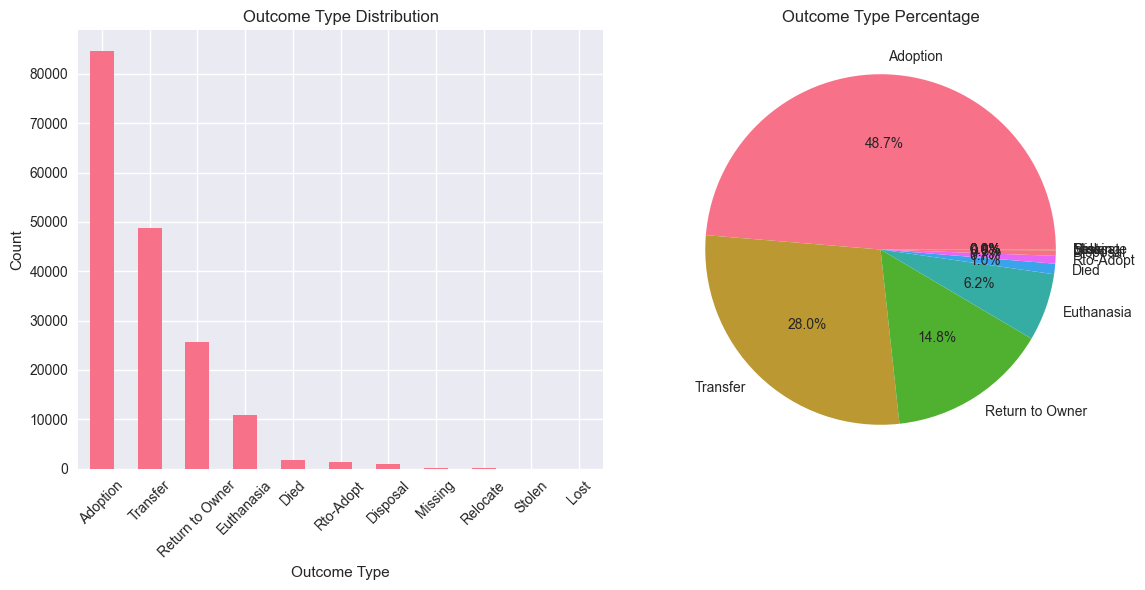

In [13]:
# Analyze outcome types and trends
print("Outcome Analysis")
print("-" * 50)

# Outcome distribution
outcome_counts = explorer.data['Outcome Type'].value_counts()
print("Outcome Type Distribution:")
for outcome, count in outcome_counts.items():
    pct = (count / len(explorer.data)) * 100
    print(f"  {outcome}: {count:,} ({pct:.1f}%)")

# Plot outcome distribution
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
outcome_counts.plot(kind='bar')
plt.title('Outcome Type Distribution')
plt.xlabel('Outcome Type')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
outcome_counts.plot(kind='pie', autopct='%1.1f%%')
plt.title('Outcome Type Percentage')
plt.ylabel('')

plt.tight_layout()
plt.show()

## Cell 6: Temporal Pattern Analysis
Understand how outcomes vary by time of day, month, and year.

Temporal Patterns
--------------------------------------------------
Converting DateTime column...
Sample DateTime values:
0    2013-12-02T00:00:00-05:00
1    2014-02-22T00:00:00-05:00
2    2014-04-07T00:00:00-05:00
3    2014-05-16T00:00:00-05:00
4    2014-06-10T00:00:00-05:00
Name: DateTime, dtype: object
DateTime column type: object
Using 3,584 records with valid dates for temporal analysis
✅ DateTime conversion successful


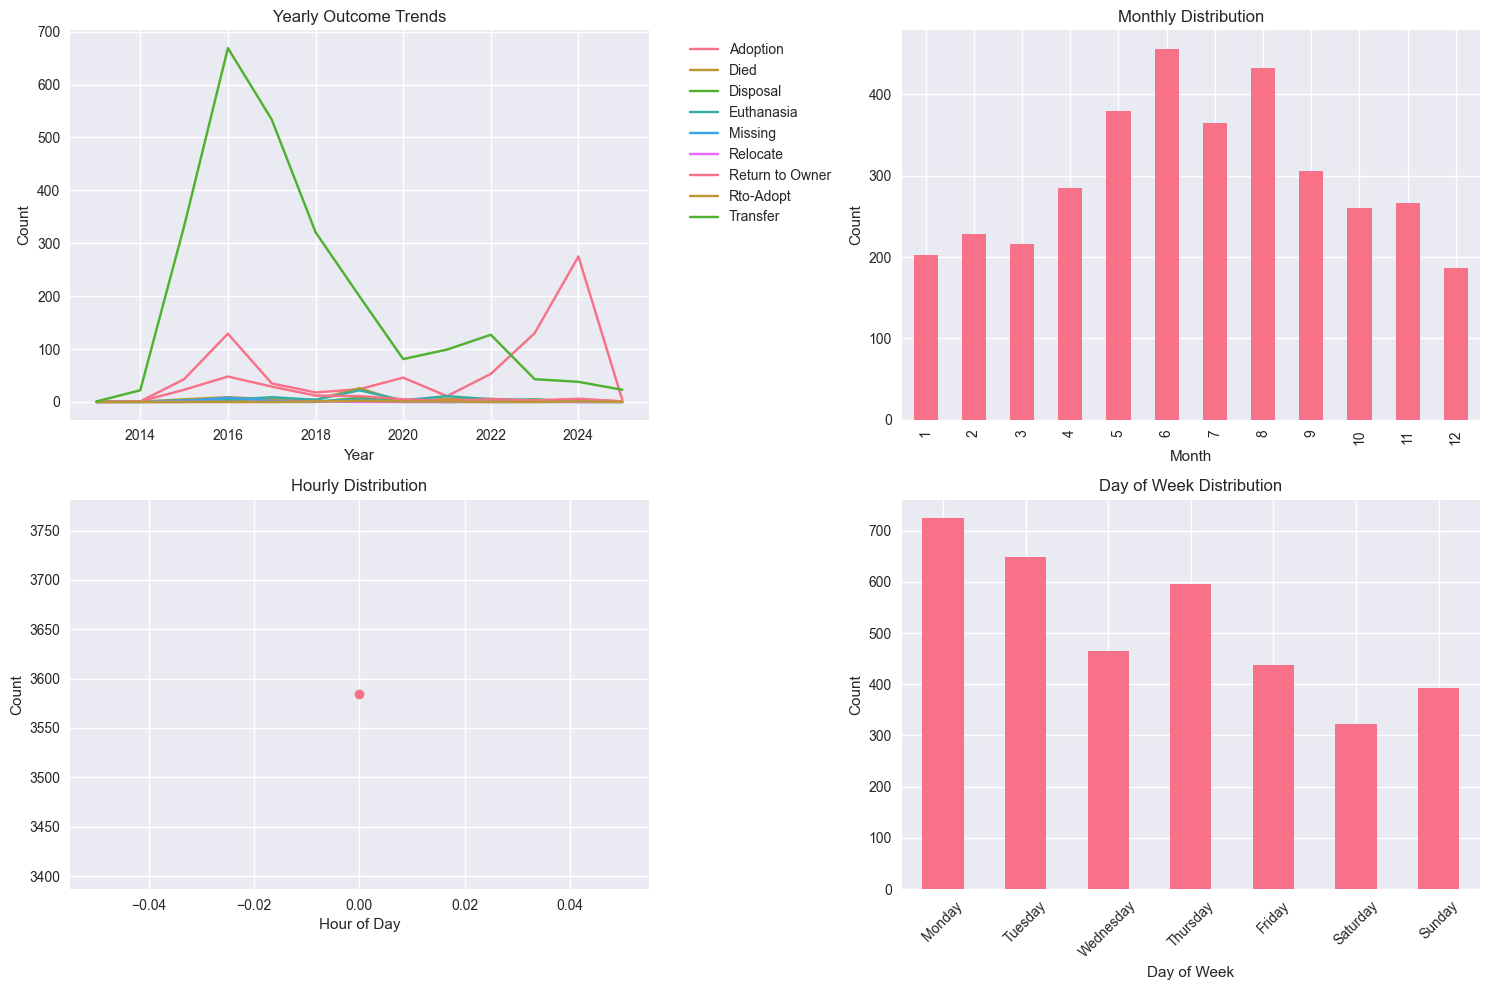

✅ Temporal analysis complete using 3,584 valid records


In [14]:
# Analyze temporal patterns in the data
print("Temporal Patterns")
print("-" * 50)

# Convert DateTime to pandas datetime with better error handling
print("Converting DateTime column...")
try:
    # First, let's see what the DateTime column looks like
    print("Sample DateTime values:")
    print(explorer.data['DateTime'].head())
    print(f"DateTime column type: {explorer.data['DateTime'].dtype}")
    
    # Convert to datetime with error handling
    explorer.data['DateTime'] = pd.to_datetime(explorer.data['DateTime'], errors='coerce')
    
    # Check for any conversion failures
    null_count = explorer.data['DateTime'].isnull().sum()
    if null_count > 0:
        print(f"Warning: {null_count} DateTime values could not be converted and were set to NaT")
    
    # Remove rows with invalid dates for temporal analysis
    valid_dates_mask = explorer.data['DateTime'].notna()
    temp_data = explorer.data[valid_dates_mask].copy()
    print(f"Using {len(temp_data):,} records with valid dates for temporal analysis")
    
    # Extract time components
    temp_data['Year'] = temp_data['DateTime'].dt.year
    temp_data['Month'] = temp_data['DateTime'].dt.month
    temp_data['Hour'] = temp_data['DateTime'].dt.hour
    temp_data['DayOfWeek'] = temp_data['DateTime'].dt.day_name()
    
    print("✅ DateTime conversion successful")
    
except Exception as e:
    print(f"❌ Error processing DateTime: {e}")
    print("Skipping temporal analysis")
    # Create a simple plot instead
    plt.figure(figsize=(8, 4))
    plt.text(0.5, 0.5, 'Temporal analysis skipped due to DateTime conversion issues', 
             ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)
    plt.title('Temporal Analysis - Conversion Error')
    plt.axis('off')
    plt.show()
    temp_data = None

# Only proceed with temporal analysis if we have valid data
if temp_data is not None and len(temp_data) > 0:
    # Yearly trends
    yearly_outcomes = temp_data.groupby(['Year', 'Outcome Type']).size().unstack(fill_value=0)

    plt.figure(figsize=(15, 10))

    # Yearly trends
    plt.subplot(2, 2, 1)
    yearly_outcomes.plot(kind='line', ax=plt.gca())
    plt.title('Yearly Outcome Trends')
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Monthly patterns
    plt.subplot(2, 2, 2)
    monthly_counts = temp_data['Month'].value_counts().sort_index()
    monthly_counts.plot(kind='bar')
    plt.title('Monthly Distribution')
    plt.xlabel('Month')
    plt.ylabel('Count')

    # Hourly patterns
    plt.subplot(2, 2, 3)
    hourly_counts = temp_data['Hour'].value_counts().sort_index()
    hourly_counts.plot(kind='line', marker='o')
    plt.title('Hourly Distribution')
    plt.xlabel('Hour of Day')
    plt.ylabel('Count')

    # Day of week patterns
    plt.subplot(2, 2, 4)
    dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    dow_counts = temp_data['DayOfWeek'].value_counts().reindex(dow_order)
    dow_counts.plot(kind='bar')
    plt.title('Day of Week Distribution')
    plt.xlabel('Day of Week')
    plt.ylabel('Count')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()
    
    # Update the main data with the converted DateTime
    explorer.data['DateTime'] = pd.to_datetime(explorer.data['DateTime'], errors='coerce')
    explorer.data.loc[valid_dates_mask, 'Year'] = temp_data['Year']
    explorer.data.loc[valid_dates_mask, 'Month'] = temp_data['Month']
    explorer.data.loc[valid_dates_mask, 'Hour'] = temp_data['Hour']
    explorer.data.loc[valid_dates_mask, 'DayOfWeek'] = temp_data['DayOfWeek']
    
    print(f"✅ Temporal analysis complete using {len(temp_data):,} valid records")

## Cell 7: Animal Characteristics Analysis
Explore animal types, breeds, ages, and how they relate to outcomes.

Animal Characteristics
--------------------------------------------------
Top Animal Types:
  Dog: 94,505 (54.4%)
  Cat: 69,399 (39.9%)
  Other: 8,960 (5.2%)
  Bird: 877 (0.5%)
  Livestock: 34 (0.0%)

Top 10 Breeds:
  Domestic Shorthair Mix: 34,039 (19.6%)
  Domestic Shorthair: 23,842 (13.7%)
  Pit Bull Mix: 10,151 (5.8%)
  Labrador Retriever Mix: 8,812 (5.1%)
  Chihuahua Shorthair Mix: 6,920 (4.0%)
  German Shepherd Mix: 4,053 (2.3%)
  Pit Bull: 3,407 (2.0%)
  Domestic Medium Hair Mix: 3,377 (1.9%)
  Bat: 2,356 (1.4%)
  Domestic Medium Hair: 2,103 (1.2%)


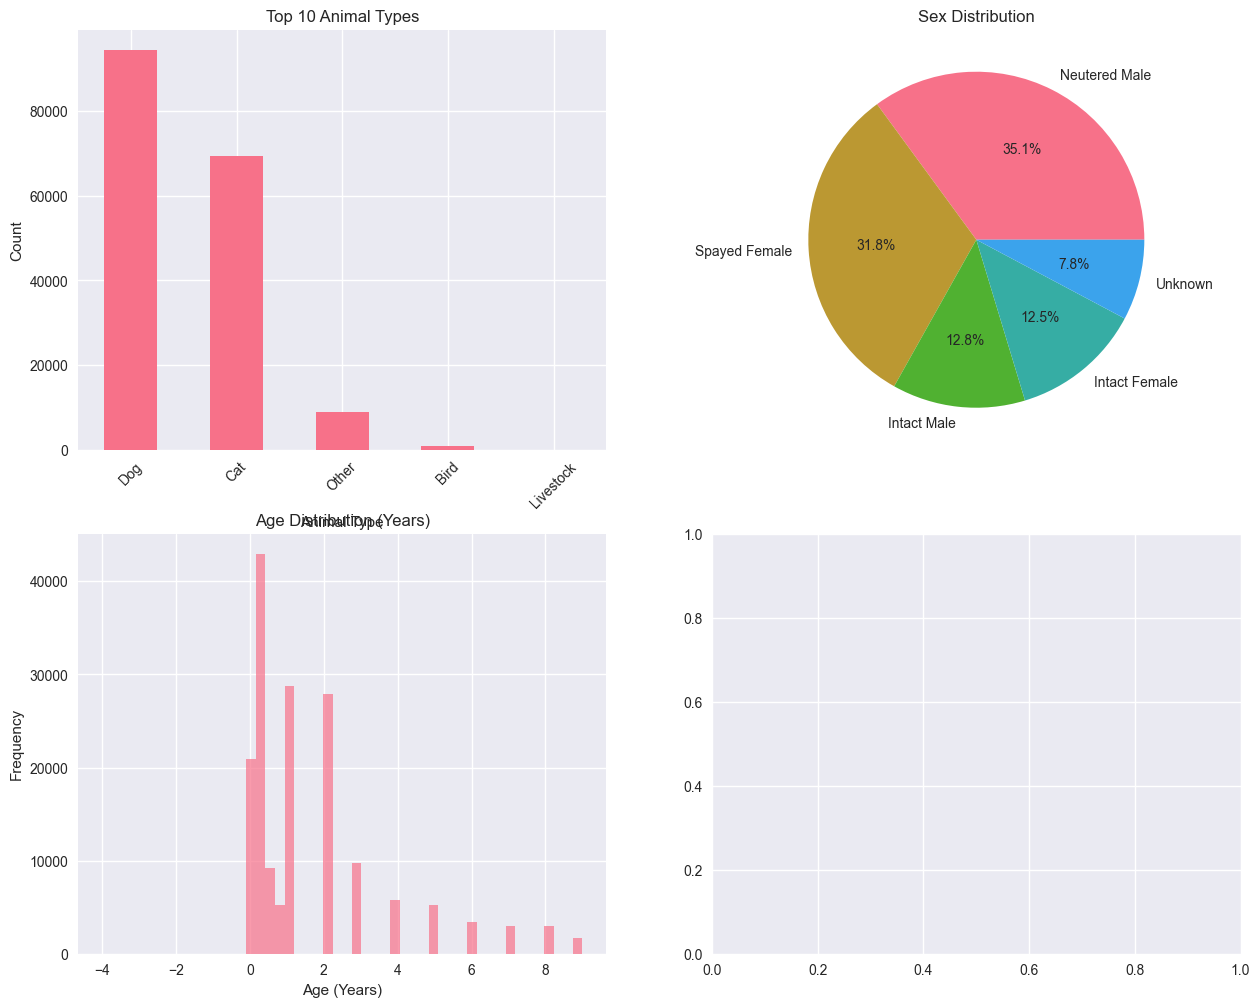

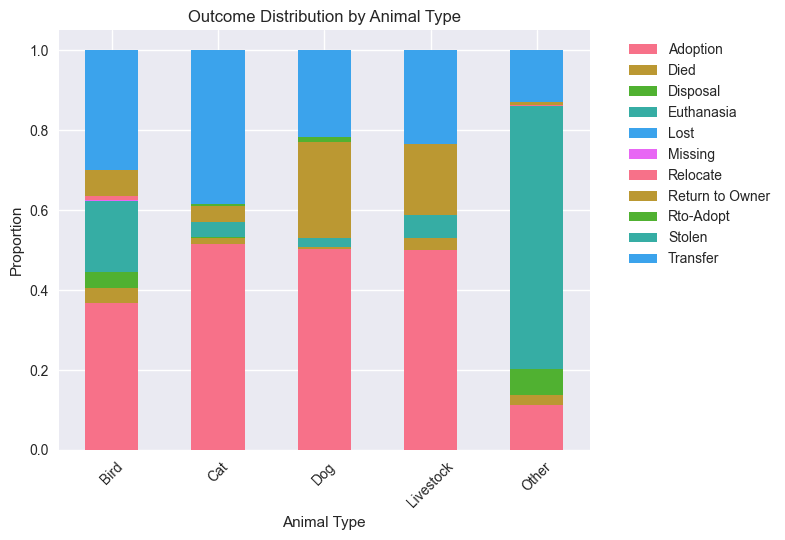

In [15]:
# Analyze animal types, breeds, and characteristics
print("Animal Characteristics")
print("-" * 50)

# Animal type distribution
animal_types = explorer.data['Animal Type'].value_counts()
print("Top Animal Types:")
for animal_type, count in animal_types.head(10).items():
    pct = (count / len(explorer.data)) * 100
    print(f"  {animal_type}: {count:,} ({pct:.1f}%)")

# Breed analysis
print("\nTop 10 Breeds:")
breed_counts = explorer.data['Breed'].value_counts()
for breed, count in breed_counts.head(10).items():
    pct = (count / len(explorer.data)) * 100
    print(f"  {breed}: {count:,} ({pct:.1f}%)")

# Create age conversion function for analysis
def convert_age_to_days(age_series):
    """Convert age strings to days"""
    def parse_age(age_str):
        if pd.isna(age_str):
            return np.nan
        
        age_str = str(age_str).lower()
        
        if 'year' in age_str:
            try:
                return float(age_str.split()[0]) * 365
            except:
                return np.nan
        elif 'month' in age_str:
            try:
                return float(age_str.split()[0]) * 30
            except:
                return np.nan
        elif 'week' in age_str:
            try:
                return float(age_str.split()[0]) * 7
            except:
                return np.nan
        elif 'day' in age_str:
            try:
                return float(age_str.split()[0])
            except:
                return np.nan
        else:
            return np.nan
            
    return age_series.apply(parse_age)

# Visualizations
plt.figure(figsize=(15, 12))

# Animal types
plt.subplot(2, 2, 1)
animal_types.head(10).plot(kind='bar')
plt.title('Top 10 Animal Types')
plt.xlabel('Animal Type')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Sex distribution
plt.subplot(2, 2, 2)
sex_counts = explorer.data['Sex upon Outcome'].value_counts()
sex_counts.plot(kind='pie', autopct='%1.1f%%')
plt.title('Sex Distribution')
plt.ylabel('')

# Age analysis (convert to numeric)
plt.subplot(2, 2, 3)
age_data = convert_age_to_days(explorer.data['Age upon Outcome'])
age_data = age_data[age_data.notna() & (age_data < 3650)]  
plt.hist(age_data / 365, bins=50, alpha=0.7)
plt.title('Age Distribution (Years)')
plt.xlabel('Age (Years)')
plt.ylabel('Frequency')

# Outcome by animal type
plt.subplot(2, 2, 4)
outcome_by_animal = pd.crosstab(explorer.data['Animal Type'], explorer.data['Outcome Type'])
outcome_by_animal.div(outcome_by_animal.sum(axis=1), axis=0).plot(kind='bar', stacked=True)
plt.title('Outcome Distribution by Animal Type')
plt.xlabel('Animal Type')
plt.ylabel('Proportion')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

## Cell 8: Generate Key Insights
Summarize the key findings from our data exploration.

In [ ]:
# Generate key insights from the data
print("Key Insights")
print("-" * 50)

total_animals = len(explorer.data)

# Outcome insights
outcomes = explorer.data['Outcome Type'].value_counts()
adoption_rate = (outcomes.get('Adoption', 0) / total_animals) * 100

print(f"Adoption Rate: {adoption_rate:.1f}%")

# Time insights
try:
    # Make sure DateTime is properly converted
    if 'DateTime' in explorer.data.columns:
        explorer.data['DateTime'] = pd.to_datetime(explorer.data['DateTime'], errors='coerce')
        valid_dates = explorer.data['DateTime'].dropna()
        
        if len(valid_dates) > 0:
            peak_hour = valid_dates.dt.hour.mode()
            peak_month = valid_dates.dt.month.mode()
            
            if len(peak_hour) > 0:
                print(f"Peak Activity Hour: {peak_hour.iloc[0]}:00")
            if len(peak_month) > 0:
                print(f"Peak Activity Month: {peak_month.iloc[0]}")
        else:
            print("⚠️  Could not analyze time patterns (no valid dates)")
    else:
        print("⚠️  No DateTime column found for time analysis")
        
except Exception as e:
    print(f"⚠️  Time analysis failed: {e}")

# Animal insights
if 'Animal Type' in explorer.data.columns:
    top_animal = explorer.data['Animal Type'].mode()
    if len(top_animal) > 0:
        print(f"Most Common Animal: {top_animal.iloc[0]}")

if 'Breed' in explorer.data.columns:
    top_breed = explorer.data['Breed'].mode()
    if len(top_breed) > 0:
        print(f"Most Common Breed: {top_breed.iloc[0]}")

# Age insights 
try:
    if 'Age upon Outcome' in explorer.data.columns:
        age_days = convert_age_to_days(explorer.data['Age upon Outcome'])
        valid_ages = age_days.dropna()
        
        if len(valid_ages) > 0:
            avg_age_years = valid_ages.mean() / 365
            print(f"Average Age: {avg_age_years:.1f} years")
        else:
            print("⚠️  Could not calculate average age (no valid age data)")
    else:
        print("⚠️  No age data found")
        
except Exception as e:
    print(f"⚠️  Age analysis failed: {e}")

print("\nData Exploration Complete!")
print("Use these insights to inform your ML model development.")

# Save processed data for ML training
print("\nSaving processed data for ML training...")
try:
    processed_data = explorer.data.copy()
    
    # Add age in days if we can calculate it
    if 'Age upon Outcome' in processed_data.columns:
        processed_data['age_in_days'] = convert_age_to_days(processed_data['Age upon Outcome'])
    
    # Ensure data directory exists
    import os
    os.makedirs('./data', exist_ok=True)
    
    # Save processed data
    processed_data.to_csv('./data/processed_animal_data.csv', index=False)
    print("✅ Processed data saved to ./data/processed_animal_data.csv")
    print(f"   Saved {len(processed_data):,} records with {len(processed_data.columns)} columns")
    
except Exception as e:
    print(f"❌ Failed to save processed data: {e}")
    print("You can still proceed with ML training using the raw data file")

Key Insights
--------------------------------------------------
Adoption Rate: 48.7%
Peak Activity Hour: 0:00
Peak Activity Month: 6
🐕 Most Common Animal: Dog
Most Common Breed: Domestic Shorthair Mix
Average Age: 2.0 years

Data Exploration Complete!
Use these insights to inform your ML model development.

Saving processed data for ML training...
✅ Processed data saved to ./data/processed_animal_data.csv
   Saved 173,775 records with 17 columns
